In [2]:
import convexgating as cg

In [3]:
!wget https://zenodo.org/record/5771937/files/data_Tcells_annotated.csv.gz 

--2023-03-07 10:11:41--  https://zenodo.org/record/5771937/files/data_Tcells_annotated.csv.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420415607 (401M) [application/octet-stream]
Saving to: ‘data_Tcells_annotated.csv.gz’

data_Tcells_annotat 100%[===================>] 400.94M  1.11MB/s    in 3m 53s  

2023-03-07 10:15:34 (1.72 MB/s) - ‘data_Tcells_annotated.csv.gz’ saved [420415607/420415607]



In [4]:
!gzip -d data_Tcells_annotated.csv.gz

# Load packages

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import os
import re

In [3]:
sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.0
colorama                    0.4.4
convexgating                NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.2
google                      NA
h5py                        3.7.0
igraph                      0.9.11
ipykernel                   6.9.0
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
kiwisolver                  1.4.4
llvmlite                    0.39.0
louvain                     0.7.1
matplotlib                  3.5.2
mpl_toolkits                NA
natsort                     8.1.0
numba       

In [4]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [5]:
df_anno = pd.read_csv('./data_Tcells_annotated.csv')

In [6]:
df_anno

AttributeError: 'DataFrame' object has no attribute 'X'

In [11]:
df_anno.head()

,cellid,Run,FCS.Filename,id,Individuals,Group,Severity,Disease.phase,max. WHO scale,sev_merge,...,IgD,IgM,Tcellcompartment,pheno_acute,metacluster_num,metacluster_name,new_clust_name,new_clust_num,UMAP1,UMAP2
0,2,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,3.507821,15.367002,CD4+,NaN,NaN,NaN,NaN,NaN,1.483736,-0.659450
1,4,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.886470,12.608067,CD8+,NaN,NaN,NaN,NaN,NaN,2.333084,-6.212416
2,12,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.000000,1.854850,CD4+,NaN,NaN,NaN,NaN,NaN,-3.276101,-5.658602
3,14,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,1.357457,0.000000,CD4+,NaN,NaN,NaN,NaN,NaN,-2.068011,-5.061034
4,26,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.000000,9.726293,CD4+,NaN,NaN,NaN,NaN,NaN,3.178484,-2.645567


In [6]:
df_anno[['Tcellcompartment', 'new_clust_name',
       'new_clust_num']].value_counts()

Tcellcompartment  new_clust_name                     new_clust_num
CD4+              CD38+                              C4               107566
                  CD226+CD25+                        C9                82698
                  CD25+                              C5                81464
CD8+              CD38+                              C24               81410
CD4+              CD226+CD25+CD11c+                  C16               72255
CD8+              PD1+TIGIT+CD137+                   C29               68770
                  CD25+                              C27               62627
CD4+              CD226+CD25+KLRB1+                  C10               55971
CD8+              CD226+LAG3+TIGIT+KLRG1+            C33               55777
CD4+              Treg-like                          C2                48773
                  CD226+CD25+CD11c+                  C11               48158
                  CD226+PD1+                         C15               48033
         

In [7]:
var_names = ['CD45',
       'CD3', 'CD19', 'CD15', 'CD8', 'TCRgd', 'CD62L', 'CD45RO', 'CD28',
       'CD27', 'CD226', 'ICOS', 'PD1', 'Lag3', 'TIGIT', 'CD96', 'CD25', 'CD56',
       'HLADR', 'CD38', 'CD137', 'CD69', 'Ki67', 'CXCR3', 'CXCR5', 'CCR6',
       'CRTH2', 'KLRB1', 'KLRG1', 'KLRF1', 'CD95', 'CD10', 'CD16', 'CD34',
       'CD123', 'CD11c', 'CD21', 'CD14', 'IgD', 'IgM']
adata_anno = ann.AnnData(X=df_anno[var_names], obs= df_anno[['cellid', 'Run', 'FCS.Filename', 'id', 'Individuals', 'Group',
       'Severity', 'Disease.phase', 'max. WHO scale', 'sev_merge',
       'Days.post.symptom.onset', 'Week', 'sev_week', 'followup', 'Tcellcompartment',
       'pheno_acute', 'metacluster_num', 'metacluster_name', 'new_clust_name',
       'new_clust_num']]) 

In [8]:
adata_CV19 = adata_anno[adata_anno.obs['Group'] == 'CV19']

In [9]:
adata_CV19.obs['Tcellcompartment'].value_counts()

CD4+      740925
CD8+      357679
TCRgd+     25228
Name: Tcellcompartment, dtype: int64

In [10]:
cofactor = 5
adata_anno.X = adata_anno.X/cofactor
adata_anno.X = np.arcsinh(adata_anno.X)

In [11]:
np.arcsinh(adata_anno.X)

array([[2.1896324 , 2.207532  , 0.        , ..., 0.        , 0.6145311 ,
        1.3703741 ],
       [2.1800835 , 2.1824768 , 0.        , ..., 0.        , 0.17547615,
        1.2778958 ],
       [2.0732162 , 2.1970012 , 0.        , ..., 0.8433143 , 0.        ,
        0.35541844],
       ...,
       [2.259369  , 2.1447139 , 0.        , ..., 0.08371744, 0.        ,
        0.        ],
       [2.1805494 , 2.1972222 , 0.        , ..., 0.7400478 , 0.        ,
        0.13428345],
       [2.216559  , 2.2399838 , 0.        , ..., 1.0574839 , 0.        ,
        0.23590712]], dtype=float32)

In [15]:
adata_anno.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1784722', '1784723', '1784724', '1784725', '1784726', '1784727',
       '1784728', '1784729', '1784730', '1784731'],
      dtype='object', length=1784732)

In [16]:
df_umap = df_anno[['UMAP1', 'UMAP2']]
df_umap.index = adata_anno.obs_names

In [19]:
adata_anno.obsm['X_umap'] = df_umap.to_numpy()

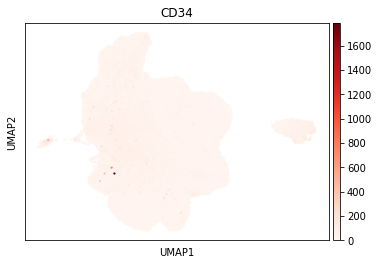

In [20]:
sc.pl.umap(adata_anno, color='CD34', size=20, cmap='Reds')

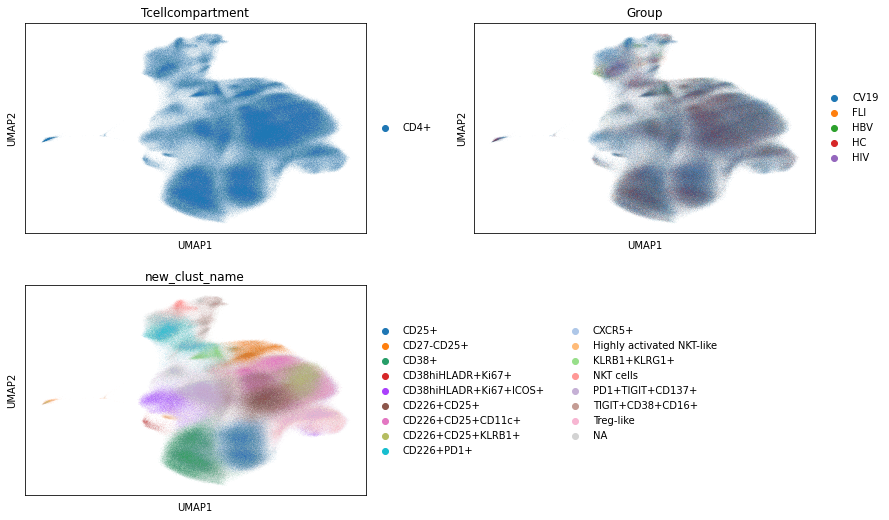

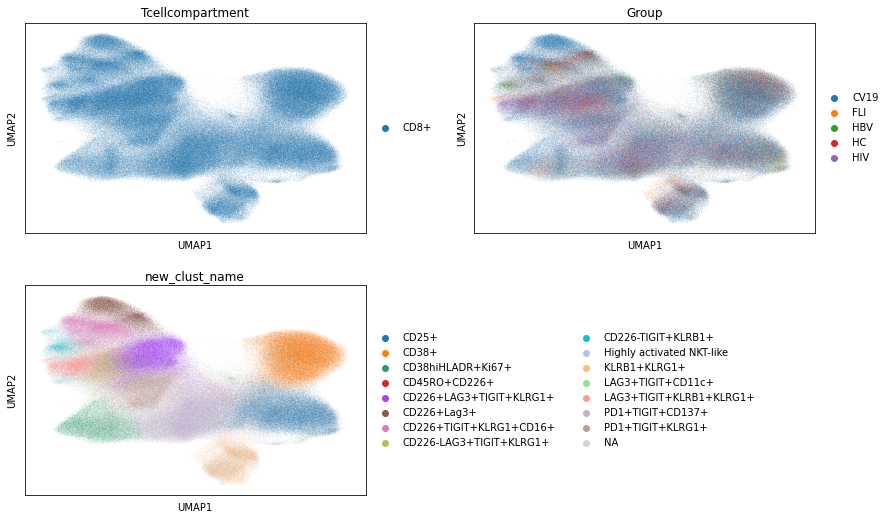

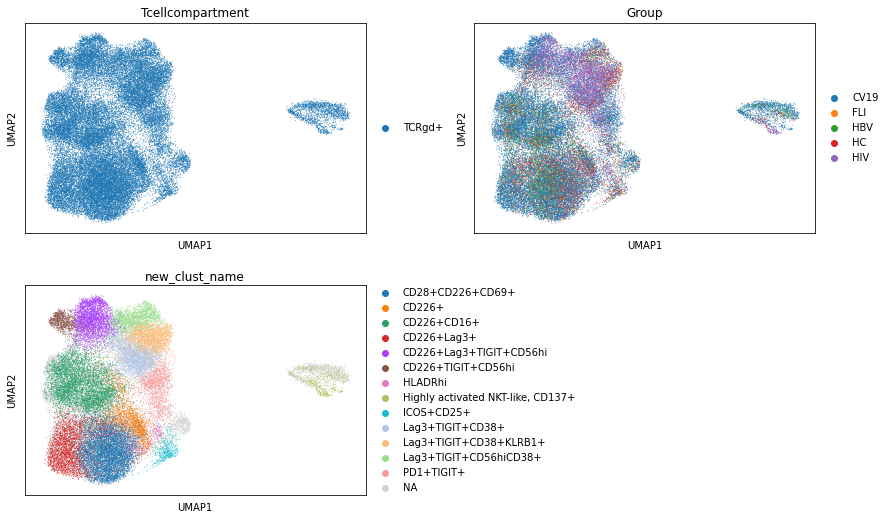

In [21]:
for comp in adata_anno.obs['Tcellcompartment'].cat.categories:
    adata_tmp= adata_anno[adata_anno.obs['Tcellcompartment']==comp].copy()
    sc.pl.umap(adata_tmp, color=['Tcellcompartment','Group', 'new_clust_name'],wspace =0.2, ncols=2)

In [26]:
adata_anno.obs['Group']

0          CV19
1          CV19
2          CV19
3          CV19
4          CV19
           ... 
1784727    CV19
1784728    CV19
1784729    CV19
1784730    CV19
1784731    CV19
Name: Group, Length: 1784732, dtype: category
Categories (5, object): ['CV19', 'FLI', 'HBV', 'HC', 'HIV']

In [12]:
adata_CV19 = adata_anno[adata_anno.obs['Group'] == 'CV19']

In [13]:
adata_CV19_CD4 = adata_CV19[adata_CV19.obs['Tcellcompartment'] == 'CD4+']

In [14]:
adata_CV19_CD8 = adata_CV19[adata_CV19.obs['Tcellcompartment'] == 'CD8+']

In [17]:
adata_CV19_CD4.obs['new_clust_num'].value_counts()

C4     59638
C5     50229
C9     38005
C16    31658
C10    27680
C2     25981
C7     25951
C11    24126
C17    19993
C15    18386
C6     18139
C18    13769
C12     7638
C1      7380
C19     7360
C14     6278
C8      2287
C3      1482
C13      750
Name: new_clust_num, dtype: int64

In [18]:
adata_CV19_CD8 = adata_CV19[adata_CV19.obs['Tcellcompartment'] == 'CD8+']

In [22]:
pd.unique(adata_CV19_CD8.obs['new_clust_num'])[1:]

array(['C22', 'C33', 'C20', 'C32', 'C30', 'C21', 'C31', 'C25', 'C29',
       'C27', 'C34', 'C28', 'C24', 'C26', 'C23'], dtype=object)

In [24]:
pd.unique(adata_CV19_CD4.obs['new_clust_num'])[1:]

array(['C15', 'C5', 'C18', 'C9', 'C19', 'C4', 'C1', 'C7', 'C6', 'C16',
       'C10', 'C11', 'C17', 'C2', 'C14', 'C12', 'C3', 'C8', 'C13'],
      dtype=object)

In [25]:
pd.unique(adata_CV19_CD4.obs['new_clust_num'])

array([nan, 'C15', 'C5', 'C18', 'C9', 'C19', 'C4', 'C1', 'C7', 'C6',
       'C16', 'C10', 'C11', 'C17', 'C2', 'C14', 'C12', 'C3', 'C8', 'C13'],
      dtype=object)

In [93]:
adata = adata_CV19_CD8.copy()
cluster_string = 'new_clust_num'
#---------------------------------------------------------------------------------


In [ ]:
cluster_numbers = ['C27']
cg.tools.gating_strategy(adata,cluster_numbers,cluster_string = cluster_string)

In [36]:
adata_CV19.obs['new_clust_num'].value_counts()

C4     59638
C5     50229
C24    45880
C9     38005
C16    31658
C10    27680
C2     25981
C7     25951
C11    24126
C27    23184
C21    21355
C29    20964
C17    19993
C15    18386
C6     18139
C25    17859
C33    17850
C20    15750
C18    13769
C30    13093
C28    10677
C12     7638
C1      7380
C19     7360
C14     6278
C32     5555
C31     4861
C22     4369
C41     2752
C35     2583
C8      2287
C42     1580
C3      1482
C45     1404
C26      892
C46      843
C13      750
C43      715
C34      700
C36      631
C47      612
C44      582
C38      412
C23      322
C48      260
C40      242
C39      205
C37      196
Name: new_clust_num, dtype: int64

In [35]:
adata_CV19.obs['new_clust_name'].value_counts()

CD38+                                105518
CD25+                                 73413
CD226+CD25+CD11c+                     55784
PD1+TIGIT+CD137+                      40957
CD226+CD25+                           38005
CD226+CD25+KLRB1+                     27680
Treg-like                             25981
CD38hiHLADR+Ki67+ICOS+                25951
CD226+Lag3+                           22935
CD38hiHLADR+Ki67+                     19341
CD226+PD1+                            18386
CXCR5+                                18139
CD226+LAG3+TIGIT+KLRG1+               17850
KLRB1+KLRG1+                          16955
CD226+TIGIT+KLRG1+CD16+               15750
CD27-CD25+                            13769
PD1+TIGIT+KLRG1+                      13093
NKT cells                              7380
TIGIT+CD38+CD16+                       7360
CD226-LAG3+TIGIT+KLRG1+                5555
LAG3+TIGIT+KLRB1+KLRG1+                4861
CD226-TIGIT+KLRB1+                     4369
Highly activated NKT-like       

In [37]:
adata_anno.obs['Tcellcompartment'] == 'CD4+'

0           True
1          False
2           True
3           True
4           True
           ...  
1784727    False
1784728    False
1784729     True
1784730    False
1784731     True
Name: Tcellcompartment, Length: 1784732, dtype: bool